# Mapping Pharmacy Deserts in New York State

This project will look at access to pharmacies in New York State to explore which communities lack access to pharmacies.

**Questions I aim to answer**:
1. A study examining "pharmacy deserts" in Chicago found they were more likely to occur in minority communities. Is the same true in New York?
2. Are pharmacy deserts more likely to occur in low income communities?

**Data Source/Collection**:

*Pharmacy data*

Approximately 86% of pharmacies participate in the state's [Medication Grant Program](https://nymgp.magellanrx.com), which provides funding for pay for the cost of reimbursing meidcations for mental illness. Data on participating pharmacies is published by the state, as well as a [count](http://www.op.nysed.gov/prof/pharm/pharmcounts.htm#stores) of pharmacies in each county, which was used to arrive at the 86% figure. (Count last updated March 2022; MGP data last updated April 2022 to reflect Q1 2022). Since this data represents such a larger proportion of the state's pharmacies, it can be used for this analysis.

*If time allows:* To chip away at the remaining 14%, because data on independent pharmacies is unavailable, I can use [Walgreens API](https://developer.walgreens.com/sites/default/files/v1_StoreLocatorAPI.html#) and [CVS API](https://developer.cvshealth.com/apis?title=&sort_by=title&sort_order=DESC&page=1) and scraped from [Rite Aid's website](https://www.riteaid.com/locations/ny.html) to acquire data on pharmacies that may not be MGP participants.

[Download MGP participating pharmacy data](https://nymgp.magellanrx.com/files/NYMGPParticipatingPharmaciesbyCounty.xlsx)

*Demographic data*

Demographic data is sourced from the American Community Survey (ACS) five year 2015-2020 data using the [Census Python package](https://pygis.io/docs/d_access_census.html), with the list of available variables [here](https://api.census.gov/data/2019/acs/acs5/variables.html)

**Analysis Steps**

1. Geocode pharmacy addresses (using geocod.io)
2. Obtain demographic data from Census
3. Statistical tests

**Useful links for reporting**
* [Counts of of CVS Pharmacy stores in NY neighborhoods](https://www.cvs.com/store-locator/cvs-pharmacy-locations/New-York)
* [WaPo: Rural America is losing its pharmacies](https://www.washingtonpost.com/business/2021/11/10/drugstore-shortage-rural-america/)
* [2007-2015 study press release by USC](https://healthpolicy.usc.edu/research/fewer-pharmacies-in-black-and-hispanic-latino-neighborhoods-compared-with-white-or-diverse-neighborhoods-2007-15/)
    * [Original study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0183172)
* [Updated study that includes NYC](https://pubmed.ncbi.nlm.nih.gov/34366287/)
* [Axios story on pharmacy deserts](https://www.axios.com/pharmacy-deserts-cities-prescriptions-45c32271-37ac-4105-b1bb-e2d2436b88c1.html)
* [State of the chains NYC 2020 report on closures](https://nycfuture.org/pdf/CUF_StateoftheChains_2020_12-23.pdf)
* [Overview article in a trade pub](https://www.drugtopics.com/view/growing-problem-pharmacy-deserts)
* [GoodRx Healthcare deserts study](https://www.goodrx.com/healthcare-access/research/healthcare-deserts-80-percent-of-country-lacks-adequate-healthcare-access)
* [Chicago study (Qato)](https://www.healthaffairs.org/doi/full/10.1377/hlthaff.2013.1397)
* [NY Pharma market overview](https://www.genrxpharmacygroup.com/market-research)
* [PCMA (the lobby for the middlemen reimnursement people) study on independent pharmacies](https://www.pcmanet.org/wp-content/uploads/2020/03/FINAL_Independent-Pharmacies-in-the-U.S.-are-More-on-the-Rise-than-on-the-Decline.pdf)
* [NY bill to regulate Pharmacy Benefit Managers](https://nystateofpolitics.com/state-of-politics/new-york/politics/2021/10/05/lawmaker---pharmacy-deserts--are-on-the-rise-in-new-york)

## Imports, Loading Data, Cleaning & Merging

In [1]:
import pandas as pd
#!pip install census
from census import Census
pd.set_option('display.max_columns', None)
import statsmodels.formula.api as smf
import seaborn
from plotnine import *
import scipy as sp
from scipy import stats
import re

In [2]:
# Pharmacy data after being geocoded by geocod.io
pharmacies = pd.read_csv('data-to-import/NYMGPParticipatingPharmaciesbyCounty_geocodio.csv') 

In [4]:
c = Census(census_api_key)

In [5]:
# B02001_002E - White population
# B02001_003E - Black population
# B02001_004E - Native American population
# B02001_005E - Asian population
# B03001_003E - Hispanic/Latino by origin 
# B16004_046E - Population above 65
# B01001_001E - Total population

ny_demographics_raw = c.acs5.state_county_tract(fields = ('NAME', 'B02001_002E', 'B02001_003E', 'B02001_004E', 
                                                          'B02001_005E', 'B03001_003E', 'B16004_046E', 'B01001_001E'),
                                                  state_fips = 36,
                                                  county_fips = "*",
                                                  tract = "*")

In [6]:
ny_demographics = pd.DataFrame(ny_demographics_raw)

In [7]:
pharmacies.columns = pharmacies.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_27266/397250458.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [8]:
# Standard fips code to merge on
ny_demographics['full_fips_tract'] = ny_demographics.state + ny_demographics.county + ny_demographics.tract
ny_demographics.full_fips_tract = ny_demographics.full_fips_tract.astype(int)

In [9]:
all_data = pharmacies.merge(ny_demographics, on='full_fips_tract', how='right')

In [10]:
# How many tracts only have one pharmacy?
all_data[all_data.npi.isna()==False].full_fips_tract.value_counts().reset_index(name='num_pharmacies').query('num_pharmacies==1')

,index,num_pharmacies
1154,36119014100,1
1155,36081062500,1
1156,36081062600,1
1157,36019103512,1
1158,36103123704,1
...,...,...
2583,36055011901,1
2584,36055011711,1
2585,36055011710,1
2586,36055011705,1


## Calculating pharmacy access by racial and ethnic group

In [11]:
majority_white = all_data[(all_data.B02001_002E / all_data.B01001_001E) >= 0.5]
majority_black = all_data[(all_data.B02001_003E / all_data.B01001_001E) >= 0.5]
majority_hispanic = all_data[(all_data.B03001_003E / all_data.B01001_001E) >= 0.5]
majority_native = all_data[(all_data.B02001_004E / all_data.B01001_001E) >= 0.5]
majority_asian = all_data[(all_data.B02001_005E / all_data.B01001_001E) >= 0.5]

In [12]:
segregated_tracts = list(majority_white.full_fips_tract) + list(majority_black.full_fips_tract) +\
                    list(majority_hispanic.full_fips_tract) + list(majority_native.full_fips_tract)+\
                    list(majority_asian.full_fips_tract)
integrated = all_data[all_data.full_fips_tract.isin(segregated_tracts) == False]

In [13]:
def get_pharma_counts(df, name):
    new = df.groupby('full_fips_tract').npi.nunique().reset_index()
    new.columns = ['full_fips_tract', 'num_pharmacies_' + name]
    return new

In [14]:
def get_normalized_pharma_counts(df):
    new = df.groupby(['full_fips_tract', 'B01001_001E']).npi.nunique().reset_index()
    new.drop(new[new.B01001_001E == 0].index, inplace=True)
    new['per_1000'] = new.npi / new.B01001_001E * 1000
    return new

In [15]:
race_income_counts = [get_pharma_counts(all_data, 'all').shape[0],
                      get_pharma_counts(majority_white, 'white').shape[0],
                      get_pharma_counts(majority_black, 'black').shape[0],
                      get_pharma_counts(majority_hispanic, 'hispanic').shape[0],
                      get_pharma_counts(majority_native, 'native').shape[0],
                      get_pharma_counts(majority_asian, 'asian').shape[0],
                      get_pharma_counts(integrated, 'integrated').shape[0]]

In [16]:
unadjusted_means = [get_pharma_counts(all_data, 'all').mean()[1],
                     get_pharma_counts(majority_white, 'white').mean()[1],
                     get_pharma_counts(majority_black, 'black').mean()[1],
                     get_pharma_counts(majority_hispanic, 'hispanic').mean()[1],
                     get_pharma_counts(majority_native, 'native').mean()[1],
                     get_pharma_counts(majority_asian, 'asian').mean()[1],
                     get_pharma_counts(integrated, 'integrated').mean()[1]]

In [17]:
adjusted_means = [get_normalized_pharma_counts(all_data).mean()[3],
                     get_normalized_pharma_counts(majority_white).mean()[3],
                     get_normalized_pharma_counts(majority_black).mean()[3],
                     get_normalized_pharma_counts(majority_hispanic).mean()[3],
                     get_normalized_pharma_counts(majority_native).mean()[3],
                     get_normalized_pharma_counts(majority_asian).mean()[3],
                     get_normalized_pharma_counts(integrated).mean()[3]]

In [18]:
t_test = pd.DataFrame(
        {'majority_race': ['all', 'white', 'black', 'hispanic', 'native', 'asian', 'integrated'],#, 'low_income'],
        'num_pharmacies': race_income_counts,
        'unadjusted_mean': unadjusted_means,
        'adjusted_mean': adjusted_means
        })

t_test

,majority_race,num_pharmacies,unadjusted_mean,adjusted_mean
0,all,5411,0.863796,0.255632
1,white,3520,0.800000,0.230799
2,black,623,0.632424,0.195906
3,hispanic,507,1.248521,0.318698
4,native,5,0.400000,0.159262
5,asian,144,1.895833,0.577239
6,integrated,685,0.910949,0.336975


In [19]:
#all vs. black
a = list(get_normalized_pharma_counts(all_data).per_1000)
b = list(get_normalized_pharma_counts(majority_black).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True) 

Ttest_indResult(statistic=2.8072963190702014, pvalue=0.0050122552537216775)

In [20]:
#all vs. hispanic
b = list(get_normalized_pharma_counts(majority_hispanic).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True) 

Ttest_indResult(statistic=-2.5631545077128823, pvalue=0.010397547531488176)

In [21]:
#all vs. white
b = list(get_normalized_pharma_counts(majority_white).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True) 

Ttest_indResult(statistic=2.444128679797735, pvalue=0.014539692172181234)

In [22]:
#all vs. native
b = list(get_normalized_pharma_counts(majority_native).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True)

Ttest_indResult(statistic=0.4140314684695158, pvalue=0.6788677926583954)

In [23]:
#all vs. asian
b = list(get_normalized_pharma_counts(majority_asian).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True)

Ttest_indResult(statistic=-6.93035985408867, pvalue=4.684082682704944e-12)

### NYC only

In [24]:
nyc_county_fips = ['061', '005', '081', '085', '047']

In [25]:
nyc_data = all_data[all_data.county_y.isin(nyc_county_fips)]

In [26]:
majority_white_nyc = nyc_data[(nyc_data.B02001_002E / nyc_data.B01001_001E) >= 0.5]
majority_black_nyc = nyc_data[(nyc_data.B02001_003E / nyc_data.B01001_001E) >= 0.5]
majority_hispanic_nyc = nyc_data[(nyc_data.B03001_003E / nyc_data.B01001_001E) >= 0.5]
majority_native_nyc = nyc_data[(nyc_data.B02001_004E / nyc_data.B01001_001E) >= 0.5]
majority_asian_nyc =  nyc_data[(nyc_data.B02001_005E / nyc_data.B01001_001E) >= 0.5]

In [27]:
segregated_tracts_nyc = list(majority_white_nyc.full_fips_tract) + list(majority_black_nyc.full_fips_tract) +\
                    list(majority_hispanic_nyc.full_fips_tract) + list(majority_native_nyc.full_fips_tract)+\
                    list(majority_asian_nyc.full_fips_tract)
integrated_nyc = all_data[all_data.full_fips_tract.isin(segregated_tracts) == False]

In [28]:
race_income_counts_nyc = [get_pharma_counts(nyc_data, 'all').shape[0],
                      get_pharma_counts(majority_white_nyc, 'white').shape[0],
                      get_pharma_counts(majority_black_nyc, 'black').shape[0],
                      get_pharma_counts(majority_hispanic_nyc, 'hispanic').shape[0],
                      get_pharma_counts(majority_native_nyc, 'native').shape[0],
                      get_pharma_counts(majority_asian_nyc, 'asian').shape[0],
                      get_pharma_counts(integrated_nyc, 'integrated').shape[0]]

In [29]:
unadjusted_means_nyc = [get_pharma_counts(nyc_data, 'all').mean()[1],
                     get_pharma_counts(majority_white_nyc, 'white').mean()[1],
                     get_pharma_counts(majority_black_nyc, 'black').mean()[1],
                     get_pharma_counts(majority_hispanic_nyc, 'hispanic').mean()[1],
                     get_pharma_counts(majority_native_nyc, 'native').mean()[1],
                     get_pharma_counts(majority_asian_nyc, 'asian').mean()[1],
                     get_pharma_counts(integrated_nyc, 'integrated').mean()[1]]

In [30]:
adjusted_means_nyc = [get_normalized_pharma_counts(nyc_data).mean()[3],
                     get_normalized_pharma_counts(majority_white_nyc).mean()[3],
                     get_normalized_pharma_counts(majority_black_nyc).mean()[3],
                     get_normalized_pharma_counts(majority_hispanic_nyc).mean()[3],
                     get_normalized_pharma_counts(majority_native_nyc).mean()[3],
                     get_normalized_pharma_counts(majority_asian_nyc).mean()[3],
                     get_normalized_pharma_counts(integrated_nyc).mean()[3]]

In [31]:
t_test_nyc = pd.DataFrame(
        {'majority_race': ['all', 'white', 'black', 'hispanic', 'native', 'asian', 'integrated'],#, 'low_income'],
        'num_pharmacies': race_income_counts_nyc,
        'unadjusted_mean': unadjusted_means_nyc,
        'adjusted_mean': adjusted_means_nyc
        })

t_test_nyc

,majority_race,num_pharmacies,unadjusted_mean,adjusted_mean
0,all,2327,1.080791,0.329174
1,white,864,1.085648,0.322414
2,black,488,0.698770,0.212047
3,hispanic,416,1.367788,0.351409
4,native,0,NaN,NaN
5,asian,140,1.928571,0.584189
6,integrated,685,0.910949,0.336975


In [32]:
#all vs. black
a = list(get_normalized_pharma_counts(nyc_data).per_1000)
b = list(get_normalized_pharma_counts(majority_black_nyc).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True) 

Ttest_indResult(statistic=3.595879686985308, pvalue=0.00032903398656474245)

In [33]:
#all vs. hispanic
b = list(get_normalized_pharma_counts(majority_hispanic_nyc).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True) 

Ttest_indResult(statistic=-0.597010536993383, pvalue=0.5505512515769517)

In [34]:
#all vs. white
b = list(get_normalized_pharma_counts(majority_white_nyc).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True) 

Ttest_indResult(statistic=0.2578803279032624, pvalue=0.796516368460395)

In [35]:
#all vs. asian
b = list(get_normalized_pharma_counts(majority_asian_nyc).per_1000)
sp.stats.ttest_ind(a, b, equal_var=True)

Ttest_indResult(statistic=-3.9338623505923422, pvalue=8.598520315580178e-05)

## Missing 14%

In [36]:
county_counts_mgp = pharmacies.county.value_counts().reset_index()

In [37]:
county_counts_mgp.columns = ['county', 'num_pharmacies_mgp']

In [38]:
county_counts = pd.read_csv('data-to-import/ny_pharmacy_counts.csv')

In [39]:
county_counts.columns = ['county', 'num_pharmacies']

In [40]:
county_counts.county = county_counts.county.str.upper()

In [41]:
county_counts = county_counts.merge(county_counts_mgp, on='county', how='outer')

In [42]:
county_counts['num_missing'] = county_counts.num_pharmacies - county_counts.num_pharmacies_mgp

In [43]:
county_counts['pct_missing'] = (county_counts.num_missing / (county_counts.num_pharmacies + county_counts.num_pharmacies_mgp)) * 100

In [44]:
county_counts.sort_values('pct_missing', ascending=False).head(10)

,county,num_pharmacies,num_pharmacies_mgp,num_missing,pct_missing
54,TOMPKINS,20,13.0,7.0,21.212121
50,SAINT LAWRENCE,29,20.0,9.0,18.367347
17,FULTON,15,11.0,4.0,15.384615
24,LEWIS,4,3.0,1.0,14.285714
22,JEFFERSON,22,17.0,5.0,12.820513
60,WYOMING,10,8.0,2.0,11.111111
8,CHENANGO,10,8.0,2.0,11.111111
40,QUEENS,846,687.0,159.0,10.371820
15,ESSEX,11,9.0,2.0,10.000000
61,YATES,6,5.0,1.0,9.090909


## Visualizations

### County Counts Map

In [45]:
ny_county_populations_raw = c.acs5.state_county(fields = ('NAME', 'B01001_001E'),
                                                      state_fips = 36,
                                                      county_fips = "*")

In [46]:
ny_county_populations = pd.DataFrame(ny_county_populations_raw)

In [47]:
ny_county_populations['county'] = ny_county_populations.NAME

In [48]:
ny_county_populations.county = ny_county_populations.county.apply(lambda x: re.search(r".*(?= County)", x, re.IGNORECASE).group(0).upper())

In [49]:
ny_county_populations.loc[ny_county_populations.county == 'ST. LAWRENCE', 'county'] = 'SAINT LAWRENCE'

In [50]:
county_counts = county_counts.merge(ny_county_populations[['county', 'B01001_001E']], on='county')

In [51]:
county_counts['pharmacies_per_10000'] = (county_counts.num_pharmacies / county_counts.B01001_001E) * 10000

In [52]:
county_counts.to_csv('viz-data/county_counts_all.csv')

In [53]:
pharmacies[pharmacies.provider_name.str.contains('WALMART')]

,nabp,npi,provider_name,address,address_line_2,city,state,postal_zip,phone,county,latitude,longitude,accuracy_score,accuracy_type,number,street,unit_type,unit_number,city,state,zip,country,source,census_year,state_fips,county_fips,place_name,place_fips,census_tract_code,census_block_code,census_block_group,full_fips_block,full_fips_tract
5,3345685.0,1053338285,WALMART PHARMACY 10-2152,141 WASHINGTON AVE EXTENSION,NaN,ALBANY,NY,12205,479-277-2500,ALBANY,42.694776,-73.847027,1.0,rooftop,141,Washington Avenue Ext,NaN,NaN,Albany,NY,12205,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36001,Albany,3601000.0,401,1029,1,3.600000e+14,36001000401
43,3335444.0,1154348381,WALMART PHARMACY 10-3583,311 ROUTE 9W,NaN,GLENMONT,NY,12077,479-277-2500,ALBANY,42.605913,-73.790796,1.0,range_interpolation,311,US Hwy 9W,NaN,NaN,Glenmont,NY,12077,US,TIGER/Line® dataset from the US Census Bureau,2021,36,36001,NaN,NaN,14201,3010,3,3.600000e+14,36001014201
53,3334860.0,1245257476,WALMART PHARMACY 10-1997,800 LOUDON RD,NaN,LATHAM,NY,12110,479-277-2500,ALBANY,42.747341,-73.762985,1.0,rooftop,800,Loudon Rd,NaN,NaN,Latham,NY,12110,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36001,Latham,3641399.0,13507,1014,1,3.600000e+14,36001013507
514,5800203.0,1881912954,WALMART PHARMACY 10-5732,2 GANNETT DR.,NaN,JOHNSON CITY,NY,13790,479-277-2500,BROOME,42.115454,-75.946966,1.0,rooftop,2,Gannett Dr,NaN,NaN,Johnson City,NY,13790,US,Broome,2021,36,36007,Johnson City,3638748.0,13800,2024,2,3.600000e+14,36007013800
523,3324302.0,1871510941,WALMART PHARMACY 10-1835,2405 VESTAL PKWY E,NaN,VESTAL,NY,13850,479-277-2500,BROOME,42.095571,-76.013360,1.0,rooftop,2405,Vestal Pkwy E,NaN,NaN,Vestal,NY,13850,US,Broome,2021,36,36007,NaN,NaN,14301,2007,2,3.600000e+14,36007014301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4443,3307407.0,1063439123,WALMART PHARMACY 10-2116,891 ROUTE 9,NaN,QUEENSBURY,NY,12804,479-277-2500,WARREN,43.336182,-73.679167,1.0,range_interpolation,891,US Hwy 9,NaN,NaN,Queensbury,NY,12804,US,TIGER/Line® dataset from the US Census Bureau,2021,36,36113,Glens Falls North,3629338.0,70701,4002,4,3.610000e+14,36113070701
4461,3353783.0,1720206469,WALMART PHARMACY 10-3842,425 ROUTE 31,NaN,MACEDON,NY,14502,479-277-2500,WAYNE,43.066465,-77.357832,1.0,rooftop,425,State Rte 31,NaN,NaN,Macedon,NY,14502,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36117,NaN,NaN,20301,1014,1,3.610000e+14,36117020303
4463,3323502.0,1144247214,WALMART PHARMACY 10-1813,6788 RT 31 EAST,NaN,NEWARK,NY,14513,479-277-2500,WAYNE,43.055548,-77.054895,1.0,range_interpolation,6788,State Rte 31 E,NaN,NaN,Newark,NY,14513,US,TIGER/Line® dataset from the US Census Bureau,2021,36,36117,NaN,NaN,21000,2055,2,3.610000e+14,36117021000
4524,3343061.0,1326065558,WALMART PHARMACY 10-2531,3133 EAST MAIN ST,NaN,MOHEGAN LAKE,NY,10547,479-277-2500,WESTCHESTER,41.310770,-73.866938,1.0,rooftop,3133,E Main St,NaN,NaN,Mohegan Lake,NY,10547,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36119,NaN,NaN,14704,1005,1,3.610000e+14,36119014704


In [54]:
#checking biggest chains
pharmacies['name_short'] = ''
pharmacies.name_short = pharmacies.apply(lambda x:re.search(r"(\S+)\b", x.provider_name).group(0), axis=1)

In [55]:
pharmacies.name_short.value_counts().nlargest(25)

CVS          565
WALGREENS    417
RITE         331
DUANE        121
WALMART       97
KINNEY        75
STOP          53
TOPS          52
WEGMANS       47
PRICE         45
HANNAFORD     45
THE           35
NEW           30
FAMILY        25
HEALTH        23
COMMUNITY     19
COSTCO        19
DRUG          15
ST            15
PHARMACY      14
GENOA         13
RX            12
ABC           12
PARK          12
CITY          12
Name: name_short, dtype: int64

In [78]:
pharmacies.query("name_short=='HANNAFORD'")

,nabp,npi,provider_name,address,address_line_2,city,state,postal_zip,phone,county,latitude,longitude,accuracy_score,accuracy_type,number,street,unit_type,unit_number,city,state,zip,country,source,census_year,state_fips,county_fips,place_name,place_fips,census_tract_code,census_block_code,census_block_group,full_fips_block,full_fips_tract,name_short,chain_marker
34,3359773.0,1689811515,HANNAFORD SUPERMARKET & PHARMACY,900 CENTRAL AVENUE,NaN,ALBANY,NY,12206,207-885-7454,ALBANY,42.679264,-73.791961,1.00,rooftop,900,Central Ave,NaN,NaN,Albany,NY,12206,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36001,Albany,3601000.0,403,1000,1,3.600000e+14,36001000403,HANNAFORD,1
36,3394676.0,1750499133,HANNAFORD FOOD AND DRUG,96 WOLF RD,NaN,ALBANY,NY,12205,207-885-7454,ALBANY,42.717693,-73.812580,1.00,rooftop,96,Wolf Rd,NaN,NaN,Albany,NY,12205,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36001,NaN,NaN,13703,1084,1,3.600000e+14,36001013703,HANNAFORD,1
37,3325760.0,1306954789,HANNAFORD FOOD AND DRUG,5239 WESTERN TURNPIKE,NaN,ALTAMONT,NY,12009,518-355-7411,ALBANY,42.718437,-73.940295,1.00,range_interpolation,5239,Western Turnpike,NaN,NaN,Altamont,NY,12009,US,TIGER/Line® dataset from the US Census Bureau,2021,36,36001,NaN,NaN,14606,1007,1,3.600000e+14,36001014606,HANNAFORD,1
41,3340382.0,1851409239,HANNAFORD FOOD AND DRUG,180 DELAWARE AVE,NaN,DELMAR,NY,12054,207-885-7454,ALBANY,42.628162,-73.811663,1.00,rooftop,180,Delaware Ave,NaN,NaN,Delmar,NY,12054,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36001,NaN,NaN,14201,1000,1,3.600000e+14,36001014201,HANNAFORD,1
48,3333820.0,1033227418,HANNAFORD FOOD AND DRUG,579 TROY SCHENECTADY,NaN,LATHAM,NY,12110,207-885-7454,ALBANY,42.755373,-73.762943,1.00,rooftop,579,Troy Schenectady Rd,NaN,NaN,Latham,NY,12110,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36001,Latham,3641399.0,13511,2010,2,3.600000e+14,36001013511,HANNAFORD,1
58,3316711.0,1295889392,HANNAFORD SUPERMARKET & PHARMACY,5 MAPLE ROAD,NaN,VOORHEESVILLE,NY,12186,207-885-7454,ALBANY,42.648989,-73.924567,0.99,rooftop,5:00 AM,Maple Rd,NaN,NaN,Voorheesville,NY,12186,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36001,Voorheesville,3677684.0,14503,2000,2,3.600000e+14,36001014503,HANNAFORD,1
626,5802536.0,1053604884,HANNAFORD SUPERMARKET & PHARMACY,7 PYRAMID DR,NaN,PLATTSBURGH,NY,129016410,518-563-3179,CLINTON,44.701138,-73.495766,1.00,rooftop,7,Pyramid Dr,NaN,NaN,Plattsburgh,NY,12901,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36019,NaN,NaN,100800,1039,1,3.600000e+14,36019100800,HANNAFORD,1
633,5804718.0,1598031346,HANNAFORD SUPERMARKET & PHARMACY,32 ROUTE 82,NaN,HUDSON,NY,125344449,518-851-2496,COLUMBIA,42.174425,-73.759326,1.00,rooftop,32,State Rte 82,NaN,NaN,Hudson,NY,12534,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36021,NaN,NaN,1400,1046,1,3.600000e+14,36021001400,HANNAFORD,1
637,3350888.0,1669552634,HANNAFORD FOOD AND DRUG,2967 STATE ROUTE 9H,SUITE 400,VALATIE,NY,12184,207-885-7454,COLUMBIA,42.427343,-73.688523,0.87,nearest_rooftop_match,2951,State Rte 9H,NaN,NaN,Valatie,NY,12184,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36021,NaN,NaN,402,3012,3,3.600000e+14,36021000402,HANNAFORD,1
677,3328766.0,1215045695,HANNAFORD FOOD AND DRUG,162 ROUTE 22,NaN,PAWLING,NY,12564,207-885-7454,DUTCHESS,41.536880,-73.583046,1.00,rooftop,162,State Rte 22,NaN,NaN,Pawling,NY,12564,US,"NYS GIS Program Office, State Geographic Infor...",2021,36,36027,NaN,NaN,110004,2021,2,3.600000e+14,36027110004,HANNAFORD,1


In [56]:
def chain_marker(row):
    chains = ['CVS ', 'RITE AID', 'WALGREENS', 'DUANE READE', 'WALMART', 'STOP AND SHOP', 
              'COSTCO', 'KINNEY', 'TOPS', 'WEGMANS', 'PRICE CHOPPER', 'HANNAFORD']
    for chain in chains:
        if chain in row.provider_name:
            return 1
    return 0

pharmacies['chain_marker'] = 0
pharmacies.chain_marker = pharmacies.apply(lambda x: chain_marker(x), axis=1)

In [57]:
chain_counts = pharmacies.groupby('county').chain_marker.sum().reset_index(name='num_chains')

In [58]:
county_counts = county_counts.merge(chain_counts, on='county')

In [59]:
county_counts['pct_chains'] = county_counts.num_chains / county_counts.num_pharmacies * 100

In [60]:
county_counts.to_csv('viz-data/county_counts_all.csv')

### Racial/Ethnic breakdown at the tract Level 

In [61]:
counts_by_tract = all_data.groupby('full_fips_tract').npi.nunique().reset_index(name='num_pharmacies')

In [62]:
counts_by_tract.loc[(all_data.B02001_002E / all_data.B01001_001E) >= 0.5, 'majority_white'] = 1
counts_by_tract.loc[(all_data.B02001_003E / all_data.B01001_001E) >= 0.5, 'majority_black'] = 1
counts_by_tract.loc[(all_data.B03001_003E / all_data.B01001_001E) >= 0.5, 'majority_hispanic'] = 1
counts_by_tract.loc[(all_data.B02001_004E / all_data.B01001_001E) >= 0.5, 'majority_native'] = 1
counts_by_tract.loc[(all_data.B02001_005E / all_data.B01001_001E) >= 0.5, 'majority_asian'] = 1
counts_by_tract.loc[all_data.full_fips_tract.isin(segregated_tracts) == False, 'integrated'] = 1
counts_by_tract = counts_by_tract.fillna(0)

In [63]:
counts_by_tract = counts_by_tract.merge(ny_demographics, on='full_fips_tract')

In [64]:
counts_by_tract['tract_code'] = counts_by_tract.county + counts_by_tract.tract

In [65]:
counts_by_tract['pharmacies_per_1000'] = (counts_by_tract.num_pharmacies / counts_by_tract.B01001_001E) * 1000

In [66]:
counts_by_tract.to_csv('viz-data/pharmacy_data_by_tract.csv')

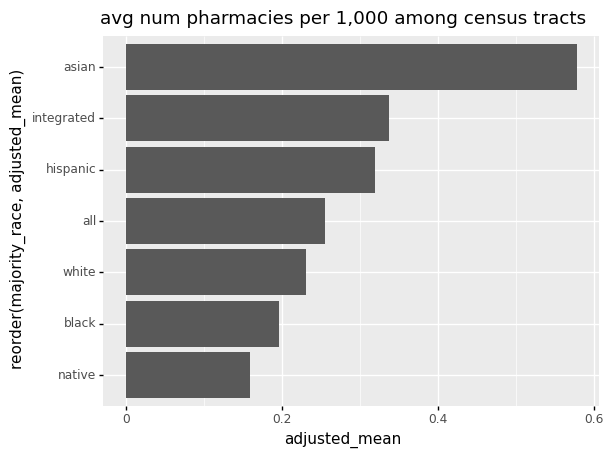

<ggplot: (314101601)>

In [67]:
display(
    ggplot(t_test)
    + aes(x='reorder(majority_race, adjusted_mean)', y='adjusted_mean')
    + geom_bar(stat='identity')
    + coord_flip()
    + labs(title='avg num pharmacies per 1,000 among census tracts')
)

/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:381: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


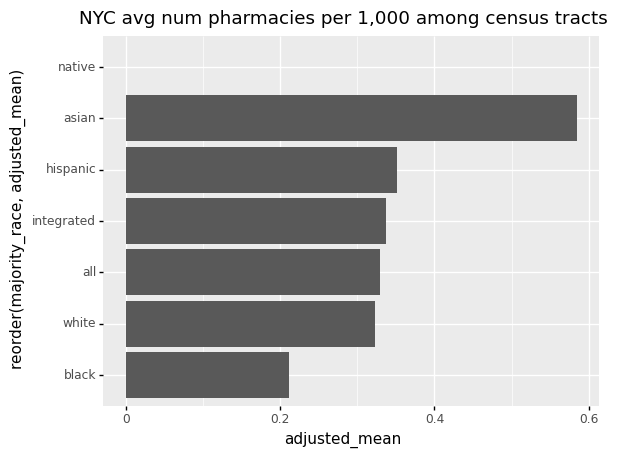

<ggplot: (314102529)>

In [68]:
display(
    ggplot(t_test_nyc)
    + aes(x='reorder(majority_race, adjusted_mean)', y='adjusted_mean')
    + geom_bar(stat='identity')
    + coord_flip()
    + labs(title='NYC avg num pharmacies per 1,000 among census tracts')
)

In [69]:
t_test_nyc.drop(t_test_nyc[t_test_nyc.majority_race.isin(['low_income', 'native'])].index).to_csv('bar_chart_city.csv')

In [70]:
multi_bar = t_test.merge(t_test_nyc, on='majority_race')
multi_bar.to_csv('multi_bar_chart.csv')

In [71]:
multi_bar


,majority_race,num_pharmacies_x,unadjusted_mean_x,adjusted_mean_x,num_pharmacies_y,unadjusted_mean_y,adjusted_mean_y
0,all,5411,0.863796,0.255632,2327,1.080791,0.329174
1,white,3520,0.800000,0.230799,864,1.085648,0.322414
2,black,623,0.632424,0.195906,488,0.698770,0.212047
3,hispanic,507,1.248521,0.318698,416,1.367788,0.351409
4,native,5,0.400000,0.159262,0,NaN,NaN
5,asian,144,1.895833,0.577239,140,1.928571,0.584189
6,integrated,685,0.910949,0.336975,685,0.910949,0.336975


In [72]:
def encode_maj_race(row):
    if row.majority_white == 1:
        return 'white'
    elif row.majority_black == 1:
        return 'black'
    elif row.majority_hispanic == 1:
        return 'hispanic'
    elif row.majority_asian == 1:
        return 'asian'
    elif row.majority_native == 1:
        return 'native'
    elif row.integrated == 1:
        return 'integrated'

In [73]:
counts_by_tract['maj_race'] = ''

In [74]:
counts_by_tract.maj_race = counts_by_tract.apply(lambda x:encode_maj_race(x), axis=1)

In [75]:
counts_by_tract.maj_race.value_counts()

white         3150
integrated     730
black          713
hispanic       688
asian          125
native           5
Name: maj_race, dtype: int64